# 3D Printer Dataset for Mechanical Engineers

In this Jupyter Notebook, I attempted to implement Trust Region Bayesian Optimisation (TurBO), a Bayesian optimisation package of PyTorch to perform Bayesian Optimisation Hyperparameter search and compare its performance against Grid Search, Random Search and HyperOpt Bayesian Optimisation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%pylab inline
import scipy as sp
import scipy.linalg as la


from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import datasets, pipeline
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
import graphviz
%matplotlib inline


from dataclasses import dataclass
import numpy as np
import torch
import math
from botorch.generation import MaxPosteriorSampling
from torch.quasirandom import SobolEngine
import botorch
import gpytorch

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("3Dprinter_data.csv")

The dataset contains 9 input parameters and 3 output parameters (Roughness(µm), Tension strength(MPa), Elongation (%))

Ideally we want Roughness -> low , Tension strength -> high and Elongation -> high (depends on materials we are working with)

In [3]:
data.head(50) # Enire Dataset

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7
5,0.02,10,40,honeycomb,200,60,40,pla,0,60,24,1.1
6,0.02,5,10,grid,205,65,40,pla,25,55,12,1.3
7,0.02,10,10,honeycomb,210,70,40,pla,50,21,14,1.5
8,0.02,9,70,grid,215,75,40,pla,75,24,27,1.4
9,0.02,8,40,honeycomb,220,80,40,pla,100,30,25,1.7


In [4]:
data.info() # Data Parameters

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tension_strenght    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [5]:
data.isnull().sum() # Checking for missing values

layer_height          0
wall_thickness        0
infill_density        0
infill_pattern        0
nozzle_temperature    0
bed_temperature       0
print_speed           0
material              0
fan_speed             0
roughness             0
tension_strenght      0
elongation            0
dtype: int64

In [6]:
for i in data.columns:
    print("{} : {}".format(i,data[i].unique()))   # Unique values in each column

layer_height : [0.02 0.06 0.1  0.15 0.2 ]
wall_thickness : [ 8  7  1  4  6 10  5  9  2  3]
infill_density : [90 80 70 40 10 20 50 30 60]
infill_pattern : ['grid' 'honeycomb']
nozzle_temperature : [220 225 230 240 250 200 205 210 215]
bed_temperature : [60 65 70 75 80]
print_speed : [ 40  60 120]
material : ['abs' 'pla']
fan_speed : [  0  25  50  75 100]
roughness : [ 25  32  40  68  92  60  55  21  24  30  75 118 200 220 126 145  88  74
 120 144 265 312 368 180 176 128 138 121 168 154 225 289 326 192 212 172
 163 276 298 360 357 321 278 244]
tension_strenght : [18 16  8 10  5 24 12 14 27 25 37  9 23 26 33 29 19 11 34 13 22  4 35 28
 21 30]
elongation : [1.2 1.4 0.8 0.5 0.7 1.1 1.3 1.5 1.7 2.4 1.  2.2 1.9 1.6 2.1 2.  0.9 0.4
 1.8 2.9 0.6 2.8 2.3 3.3 3.1 2.7 3.2]


In [7]:
data['infill_pattern'].replace(['grid','honeycomb'], [0,1], inplace = True)
data['material'].replace(['abs','pla'], [0,1], inplace = True)

data.head(50)  # Replace categorical values with numerical values

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7
5,0.02,10,40,1,200,60,40,1,0,60,24,1.1
6,0.02,5,10,0,205,65,40,1,25,55,12,1.3
7,0.02,10,10,1,210,70,40,1,50,21,14,1.5
8,0.02,9,70,0,215,75,40,1,75,24,27,1.4
9,0.02,8,40,1,220,80,40,1,100,30,25,1.7


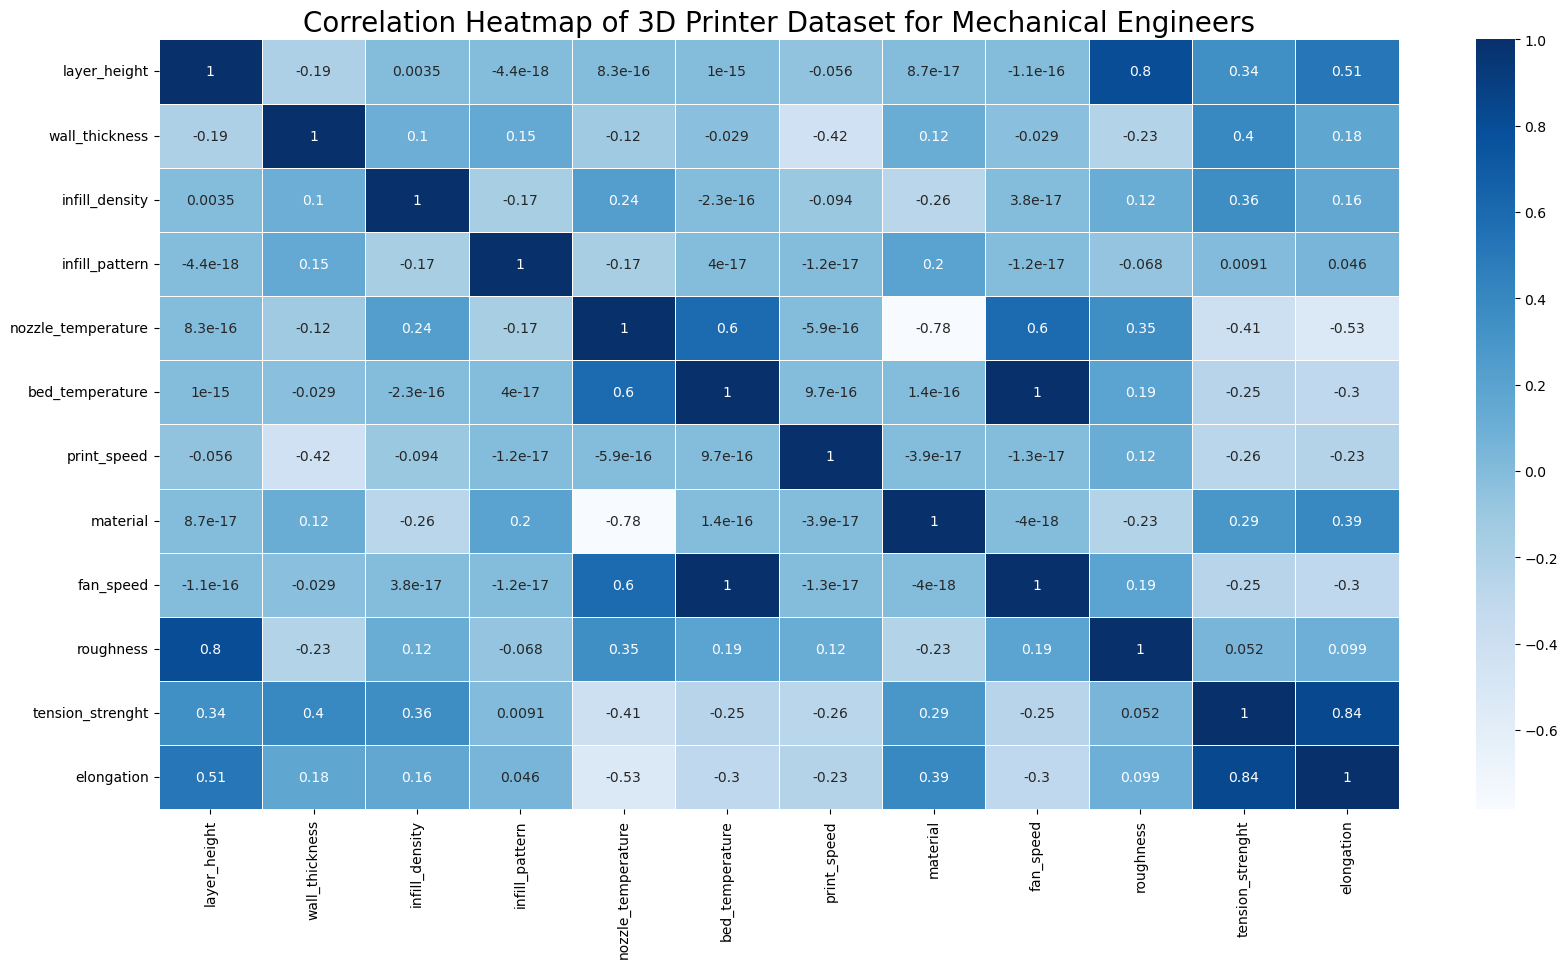

In [8]:
fig, ax = plt.subplots(figsize = (20,10))
plt.title("Correlation Heatmap of 3D Printer Dataset for Mechanical Engineers", fontsize = 20)
sns.heatmap(data.corr(method = "pearson"), cbar = True, cmap = 'Blues', annot = True, linewidths = 0.5, ax = ax)
plt.show()  # Generate heatmap for evaluating correlations between variables

The heatmap exhibits some interesting correlations between the different parameters. Most notably, the positive correlation between layer height and material roughness

It is worth exploring how the 9 input parameters influence Material Roughness

# Grid Search, Random Search and HyperOpt

In [9]:
X = data.drop(['roughness','tension_strenght','elongation'], axis = 1)
Y = data.loc[:, ['roughness']]

In [10]:
X.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed
0,0.02,8,90,0,220,60,40,0,0
1,0.02,7,90,1,225,65,40,0,25
2,0.02,1,80,0,230,70,40,0,50
3,0.02,4,70,1,240,75,40,0,75
4,0.02,6,90,0,250,80,40,0,100


In [11]:
Y.head()

,roughness
0,25
1,32
2,40
3,68
4,92


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

In [13]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(33, 9) (17, 9) (33, 1) (17, 1)


In [14]:
# Hyperparameter tuning for Grid Search, Random Search, HyperOpt
pipe = pipeline.Pipeline([('clf', lgb.LGBMRegressor())])

param_gridsearch = {
    'clf__learning_rate' : [1],
    'clf__max_depth': [3],
    'clf__n_estimators': [5],
    'clf__num_leaves': [5],
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree': [1],
    'clf__reg_lambda': [3],
}

param_random = {
    'clf__learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 5, base=1)),
    'clf__max_depth': list(range(1, 10)),
    'clf__n_estimators': list(range(1, 10)),
    'clf__num_leaves': list(range(1, 10)),
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'clf__reg_lambda': list(np.linspace(0, 1, 10)),
}

param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 1, 10, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 10, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

In [15]:
def search(pipeline, parameters, X_train, Y_train, X_test, Y_test, optimizer='grid_search', n_iter=None):
    
    start = time.time() 
    
    if optimizer == 'grid_search':
        grid_obj = GridSearchCV(estimator=pipeline,
                                param_grid=parameters,
                                cv=5,
                                refit=True,
                                return_train_score=False,
                                scoring = 'accuracy',
                               )
        grid_obj.fit(X_train, Y_train,)
    
    elif optimizer == 'random_search':
        grid_obj = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=parameters,
                            cv=5,
                            n_iter=n_iter,
                            refit=True,
                            return_train_score=False,
                            scoring = 'accuracy',
                            random_state=1)
        grid_obj.fit(X_train, Y_train,)
    
    else:
        print('enter search method')
        return

    estimator = grid_obj.best_estimator_
    cvs = cross_val_score(estimator, X_train, Y_train, cv=5)
    results = pd.DataFrame(grid_obj.cv_results_)
    
    print("Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    print("Cross-validation Score: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, Y_test))
    print("Time elapsed: ", time.time() - start)

In [16]:
num_eval = 5
#results_grid, estimator_grid = search(pipe, param_gridsearch, X_train, y_train, X_test, y_test, 'grid_search')
results_random, estimator_random = search(pipe, param_random, X_train, Y_train, X_test, Y_test, 'random_search', num_eval)

C:\Users\davew\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 93, in _check_targets
    raise 

Results
Score best parameters:  nan
Best parameters:  {'clf__reg_lambda': 0.7777777777777777, 'clf__num_leaves': 6, 'clf__n_estimators': 1, 'clf__max_depth': 6, 'clf__learning_rate': 1.0, 'clf__colsample_bytree': 0.7333333333333333, 'clf__boosting_type': 'gbdt'}
Cross-validation Score:  -0.16222539334840108
Test Score:  -0.09333748099552075
Time elapsed:  0.23122739791870117


TypeError: cannot unpack non-iterable NoneType object

In [17]:
def hyperopt(param_space, X_train, Y_train, X_test, Y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = lgb.LGBMRegressor(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
    
    clf_best = lgb.LGBMRegressor(learning_rate=best_param_values[2],
                                  num_leaves=int(best_param_values[5]),
                                  max_depth=int(best_param_values[3]),
                                  n_estimators=int(best_param_values[4]),
                                  boosting_type=boosting_type,
                                  colsample_bytree=best_param_values[1],
                                  reg_lambda=best_param_values[6],
                                 )
                                  
    clf_best.fit(X_train, Y_train)

    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials


In [18]:
num_eval = 5
results_hyperopt = hyperopt(param_hyperopt, X_train, Y_train, X_test, Y_test, num_eval)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]


AttributeError: 'numpy.random.mtrand.RandomState' object has no attribute 'integers'

In [19]:
num_eval = 5

results_grid, estimator_grid = search(pipe, param_gridsearch, X_train, Y_train, X_test, Y_test, 'grid_search')
results_random, estimator_random = search(pipe, param_random, X_train, Y_train, X_test, Y_test, 'random_search', num_eval)
results_hyperopt = hyperopt(param_hyperopt, X_train, Y_train, X_test, Y_test, num_eval)

Results
Score best parameters:  nan
Best parameters:  {'clf__boosting_type': 'gbdt', 'clf__colsample_bytree': 1, 'clf__learning_rate': 1, 'clf__max_depth': 3, 'clf__n_estimators': 5, 'clf__num_leaves': 5, 'clf__reg_lambda': 3}
Cross-validation Score:  -0.16222539334840108
Test Score:  -0.09333748099552075
Time elapsed:  0.10810065269470215


C:\Users\davew\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Users\davew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 93, in _check_targets
    raise 

TypeError: cannot unpack non-iterable NoneType object

# TurBO

In [20]:
# Data must be normalised for TurBO as the algorithm only accepts inputs between [0, 1]

def NormalizeData(data):   
    return (data - np.min(data)) / (np.max(data) - np.min(data))

NormalizeData(data)

C:\Users\davew\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\davew\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.000000,0.777778,1.000,0.0,0.4,0.00,0.00,0.0,0.00,0.011527,0.424242,0.275862
1,0.000000,0.666667,1.000,1.0,0.5,0.25,0.00,0.0,0.25,0.031700,0.363636,0.344828
2,0.000000,0.000000,0.875,0.0,0.6,0.50,0.00,0.0,0.50,0.054755,0.121212,0.137931
3,0.000000,0.333333,0.750,1.0,0.8,0.75,0.00,0.0,0.75,0.135447,0.181818,0.034483
4,0.000000,0.555556,1.000,0.0,1.0,1.00,0.00,0.0,1.00,0.204611,0.030303,0.103448
5,0.000000,1.000000,0.375,1.0,0.0,0.00,0.00,1.0,0.00,0.112392,0.606061,0.241379
6,0.000000,0.444444,0.000,0.0,0.1,0.25,0.00,1.0,0.25,0.097983,0.242424,0.310345
7,0.000000,1.000000,0.000,1.0,0.2,0.50,0.00,1.0,0.50,0.000000,0.303030,0.379310
8,0.000000,0.888889,0.750,0.0,0.3,0.75,0.00,1.0,0.75,0.008646,0.696970,0.344828
9,0.000000,0.777778,0.375,1.0,0.4,1.00,0.00,1.0,1.00,0.025937,0.636364,0.448276


In [21]:
X = NormalizeData(X)

X.head()

C:\Users\davew\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\davew\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed
0,0.0,0.777778,1.000,0.0,0.4,0.00,0.0,0.0,0.00
1,0.0,0.666667,1.000,1.0,0.5,0.25,0.0,0.0,0.25
2,0.0,0.000000,0.875,0.0,0.6,0.50,0.0,0.0,0.50
3,0.0,0.333333,0.750,1.0,0.8,0.75,0.0,0.0,0.75
4,0.0,0.555556,1.000,0.0,1.0,1.00,0.0,0.0,1.00


In [22]:
Y = NormalizeData(Y)

Y.head()

C:\Users\davew\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\davew\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


,roughness
0,0.011527
1,0.031700
2,0.054755
3,0.135447
4,0.204611


In [23]:
@dataclass
class TurboState:
    dim: int = 9 
    batch_size: int = 1 
    length: float = 0.8 
    length_min: float = 0.5 ** 7 
    length_max: float = 1.6 
    failure_counter: int = 0 
    failure_tolerance: int = float("nan")  
    success_counter: int = 0 
    success_tolerance: int = 10  
    best_value: float = -float("inf") 
    restart_triggered: bool = False 

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
   
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1
   
    if state.success_counter == state.success_tolerance:  
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  
        state.length /= 2.0
        state.failure_counter = 0
  
    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

In [24]:
state = TurboState(dim = 9)
print(state)

TurboState(dim=9, batch_size=1, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=9, success_counter=0, success_tolerance=10, best_value=-inf, restart_triggered=False)


In [25]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size = 1, # fix batch size to 1
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)
 
    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = (
            torch.rand(n_candidates, dim)
            <= prob_perturb
        )
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),))] = 1

        # Create candidate points from the perturbations and the mask        
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        # set model to evaluation mode
        model.eval()
        posterior_distribution = model(X_cand)
        with torch.no_grad():  # We don't need gradients when using TS
            posterior_sample = posterior_distribution.sample()
            X_next_idx = torch.argmax(posterior_sample)
            X_next = X_cand[X_next_idx]

    return X_next

In [26]:
# Hyperparameter training 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
       
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))
        
        self.training_iter = 200

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

This is a highly complex unknow function with 9 variables - impossible to guess what correct function may be

Utilised a model function (similar to what was covered in webinar)

$$f(x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9) = x_3 * \sin(x_1) * \cos(x_2) + x_4 * x_5 - x_6 * x_5^2 + x_7 * x_8 * x_9^2$$

In [27]:
func = lambda x: torch.sin(x[:, 0]) * torch.cos(x[:, 1]) * x[:, 2] + x[:, 3] * x[:, 4] - x[:, 5] * (x[:, 4]**2) + x[:, 6] * x[:, 7] * (x[:, 8]**2)

train_x = torch.rand(size = torch.Size([15, 9]))
train_y = func(train_x)

state = TurboState(dim = 9, best_value = torch.max(train_y).float())

In [28]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()


optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


for i in range(model.training_iter):

    optimizer.zero_grad()

    output = model(train_x)

    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 9:
        print(f'Iter %d/%d - Loss: %.3f   lengthscale: {model.covar_module.base_kernel.lengthscale.detach()}   noise: %.3f' % (
            i + 1, model.training_iter, loss.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

RuntimeError: Calling torch.linalg.cholesky on a CPU tensor requires compiling PyTorch with LAPACK. Please use PyTorch built with LAPACK support.

In [29]:
def next_query_via_TurBO(train_x, train_y, turbo_state, verbose = False):
   
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    for i in range(model.training_iter):
        optimizer.zero_grad()

        output = model(train_x)
       
        loss = -mll(output, train_y)
        loss.backward()
        if (i % 10 == 9) & verbose:
            print(f'Iter %d/%d - Loss: %.3f   lengthscale: {model.covar_module.base_kernel.lengthscale}   noise: %.3f' % (
                i + 1, model.training_iter, loss.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()
    
    return generate_batch(turbo_state, model = model, X = train_x, Y = train_y)

In [30]:
next_query = next_query_via_TurBO(train_x=train_x, train_y=train_y, turbo_state=state)
print(f'Next chose query: {next_query}')

RuntimeError: Calling torch.linalg.cholesky on a CPU tensor requires compiling PyTorch with LAPACK. Please use PyTorch built with LAPACK support.

In [31]:
print('State at latest optimization loop:')
print()
print(state)

State at latest optimization loop:

TurboState(dim=9, batch_size=1, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=9, success_counter=0, success_tolerance=10, best_value=tensor(0.7637), restart_triggered=False)


In [32]:
y_next = func(next_query.reshape(1, -1))
print(y_next)

NameError: name 'next_query' is not defined

In [33]:
new_state = update_state(state, y_next)

NameError: name 'y_next' is not defined

In [34]:
train_x = torch.concat((train_x, next_query.reshape(1, -1)), dim = 0)
train_y = torch.concat((train_y, y_next))

next_next_query = next_query_via_TurBO(train_x, train_y, new_state)
print(f'New query:', next_next_query)

NameError: name 'next_query' is not defined